In [16]:
import pickle
import pandas as pd
import numpy as np
import os, sys, gc 
from plotnine import *
import plotnine
import scipy
import torch
import torch.nn.functional as F
from torch import nn
import matplotlib.pyplot as plt
import torch.nn.init as weight_init
%matplotlib inline

from tqdm.notebook import tqdm as tqdm_notebook
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl
from matplotlib import rc
import re
from matplotlib.ticker import PercentFormatter
import datetime
from math import log

In [138]:
movie = pd.read_csv('/Linux/Data/recommendation/ratings.zip')
movie

,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4
...,...,...,...
981751,10000,48386,5
981752,10000,49007,4
981753,10000,49383,5
981754,10000,50124,5


In [143]:
user2idx = {}
for i, l in enumerate(df['user_id'].unique()):
    user2idx[l] = i

movie2idx = {}
for i, l in enumerate(df['item_id'].unique()):
    movie2idx[l] = i

idx2user = {i: user for user, i in user2idx.items()}
idx2movie = {i: item for item, i in movie2idx.items()}

In [144]:
useridx = df['useridx'] = df['user_id'].apply(lambda x: user2idx[x]).values
movieidx = df['movieidx'] = df['item_id'].apply(lambda x: movie2idx[x]).values
rating = df['rating'].values

In [145]:
n_users = df['user_id'].nunique()
n_items = df['item_id'].nunique()

In [146]:
ratings = scipy.sparse.csr_matrix((rating, (useridx, movieidx)), shape=(len(set(useridx)), len(set(movieidx))))

In [33]:
class MatrixFactorization(nn.Module):
    def __init__(self, R, n_users, n_items, n_factors=20):
        super().__init__() # 부모 클래스(torch.nn.Module)의 init을 불러옴 
        self.user_factors = nn.Embedding(n_users, n_factors)
        self.item_factors = nn.Embedding(n_items, n_factors)
        
        # weight 초기화 
        weight_init.xavier_uniform_(self.user_factors.weight)
        weight_init.xavier_uniform_(self.item_factors.weight)
       
        # original Matrix 
        self.R = R
        
    def forward(self, user, item):
        pred = (self.user_factors(user) * self.item_factors(item)).sum(1)
        return pred
    
    def complete_matrix(self):
        return torch.matmul(self.user_factors.weight, self.item_factors.weight.T)

In [335]:
model = MatrixFactorization(ratings, n_users, n_items, n_factors=20)

In [336]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
optimizer = torch.optim.SGD(model.parameters(), lr=5e-3)  # learning rate
loss_func = torch.nn.MSELoss()

In [337]:
rows, cols = ratings.nonzero()

nb_epochs = 10
for epoch in tqdm_notebook(range(nb_epochs)):
    train_loss = 0
    for row, col in zip(*(rows, cols)):
        # gradient 값을 0으로 설정 
        optimizer.zero_grad()

        # 데이터를 Tensor형태로 변환 
        rating = torch.FloatTensor([ratings[row, col]])
        row = torch.LongTensor([row])
        col = torch.LongTensor([col])

        # 예측값을 만들고 Loss를 계산 
        prediction = model(row, col)
        loss = loss_func(prediction, rating)
        train_loss += loss.item()
        
        # 역전파 
        loss.backward()

        # 파라미터를 갱신
        optimizer.step()
    #cost_ = model.cost()
    print('Epoch {:4d}/{} Loss: {:.6f}'.format(epoch+1, nb_epochs, train_loss/len(rows)))

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch    1/10 Loss: 7.856273
Epoch    2/10 Loss: 1.687828
Epoch    3/10 Loss: 1.034904
Epoch    4/10 Loss: 0.945540
Epoch    5/10 Loss: 0.908203
Epoch    6/10 Loss: 0.881172
Epoch    7/10 Loss: 0.855516
Epoch    8/10 Loss: 0.829090
Epoch    9/10 Loss: 0.801913
Epoch   10/10 Loss: 0.773990


In [147]:
items = torch.LongTensor(df['movieidx'])
users = torch.LongTensor(df['useridx'])
numitem = items.max() + 1
numuser = users.max() + 1

In [148]:
numitem, numuser

(tensor(1682), tensor(943))

In [150]:
items = torch.LongTensor(df_train['movieidx'].to_numpy())
users = torch.LongTensor(df_train['useridx'].to_numpy())
ratings = torch.FloatTensor(df_train['rating'].to_numpy())
items_test = torch.LongTensor(df_test['movieidx'].to_numpy())
users_test = torch.LongTensor(df_test['useridx'].to_numpy())
ratings_test = torch.FloatTensor(df_test['rating'].to_numpy())
numitem = items.max() + 1
numuser = users.max() + 1

In [7]:
train = pd.read_csv("/Linux/Data/recommendation/ml-100k/ua.base", sep="\t", names=['user', 'movie', 'rating', 'timestamp'])
test = pd.read_csv("/Linux/Data/recommendation/ml-100k/ua.test", sep="\t", names=['user', 'movie', 'rating', 'timestamp'])

In [10]:
items = torch.LongTensor(train['movie'])
users = torch.LongTensor(train['user'])
ratings = torch.FloatTensor(train['rating'])
items_test = torch.LongTensor(test['movie'])
users_test = torch.LongTensor(test['user'])
ratings_test = torch.FloatTensor(test['rating'])

In [83]:
def quantile_loss(preds, target, quantiles):
    assert not target.requires_grad
    assert preds.size(0) == target.size(0)
    losses = []
    for i, q in enumerate(quantiles):
        errors = target - preds[i]
        losses.append(torch.max((q - 1) * errors, q * errors).unsqueeze(1))
    loss = torch.mean(torch.sum(torch.cat(losses, dim = 1), dim = 1))
    return loss

In [84]:
quantile_loss(hypothesis, ratings, quantiles)

tensor(2.3350, grad_fn=<MeanBackward0>)

In [23]:
quantiles = (0.2, 0.5, 0.8)

In [76]:
def quantile_loss2(preds, target, quantiles):
    assert not target.requires_grad
    assert preds.size(0) == target.size(0)
    losses = []
    loss = []
    for i, q in enumerate(quantiles):
        errors = target - preds[i]
        losses.append(torch.max((q - 1) * errors, q * errors).unsqueeze(1))
        loss.append(torch.mean(torch.sum(losses[i], dim = 1)))
#        loss = torch.mean(torch.sum(torch.cat(losses, dim = 1), dim = 1))
    return loss

In [77]:
quantile_loss2(hypothesis, ratings, quantiles)

[tensor(0.3434, grad_fn=<MeanBackward0>),
 tensor(0.4570, grad_fn=<MeanBackward0>),
 tensor(0.2973, grad_fn=<MeanBackward0>)]

In [72]:
ql3 = quantile_loss2(hypothesis, ratings, quantiles)[1][1]
ql4 = quantile_loss2(hypothesis, ratings, quantiles)[1][2]

In [59]:
qqq = quantile_loss2(hypothesis, ratings, quantiles)[1]
qqq2 = torch.cat(qqq, dim = 1)
qqq2

tensor([[0.4095, 0.5840, 0.1608],
        [0.0095, 0.4160, 0.3598],
        [0.2095, 0.0840, 0.1598],
        ...,
        [0.0095, 0.4160, 0.3598],
        [0.0095, 0.4160, 0.3598],
        [0.0095, 0.4160, 0.3598]], grad_fn=<CatBackward>)

epoch: 0, cost: 4.791550
epoch: 100, cost: 1.117686
epoch: 200, cost: 1.119316
epoch: 300, cost: 1.103154
epoch: 400, cost: 1.094417
epoch: 500, cost: 1.095909
epoch: 600, cost: 1.106351
epoch: 700, cost: 1.096326
epoch: 800, cost: 1.091463
epoch: 900, cost: 1.098816


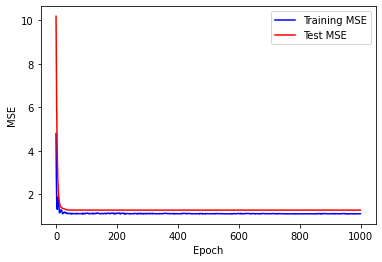

In [15]:
rank = 10
numItems = items.max() + 1
numUsers = users.max() + 1
P = torch.randn(numItems, rank, requires_grad=True)
Q = torch.randn(numUsers, rank, requires_grad=True)

# Global Baseline Estimate 적용시 bias_item, bias_user, Pi, Qx를 정규화하기 위해 사용
lambda1 = 0.0001
lambda2 = 0.0001
lambda3 = 0.001
lambda4 = 0.001

# 각 item, user 벡터에 적용할 bias 값
# 학습해야하는 파라미터이기에 랜덤한 값으로 채워넣는다.
bias_item = torch.randn(numItems, requires_grad=True)
bias_user = torch.randn(numUsers, requires_grad=True)

# 전체 평점 평균 (Global Baseline Estimate를 적용한 Latent Factor model의 가설함수에 필요)
mean = (ratings.sum() / len(ratings)).item()

optimizer = torch.optim.Adam([P, Q, bias_item, bias_user], lr= 0.1)

X = []
Y = []
Y_test = []

for epoch in range(1000):

        # 가설 = 예상별점(아이템벡터와 유저벡터 내적) + 전체평점평균 + 아이템벡터의 bias + 유저벡터의 bias
    hypothesis = torch.sum(P[items] * Q[users], dim=1) + mean + bias_item[items] + bias_user[users]

        # 비용 = MSE + 정규화
    cost = quantile_loss(hypothesis, ratings, quantiles)
    loss = cost + lambda1 * torch.sum(P ** 2) + lambda2 * torch.sum(Q ** 2) + lambda3 * torch.sum(bias_item ** 2) + lambda4 * torch.sum(bias_user ** 2) 

    # 기울기 계산
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # 기울기 계산 필요 없다.
    with torch.no_grad():
                # 만들어진 P, Q matrix로 예측값을 뽑아내고 검증데이터와 비교한다.

                # 가설 = 예상별점(아이템벡터와 유저벡터 내적) + 전체평점평균 + 아이템벡터의 bias + 유저벡터의 bias
        hypo_test = torch.sum(P[items_test] * Q[users_test], dim=1)+ mean + bias_item[items_test] + bias_user[users_test]

                # 비용 = MSE
        cost_test = F.mse_loss(hypo_test, ratings_test)

                # cost 결과 작성
        X.append(epoch)
        Y.append(cost)
        Y_test.append(cost_test)

    if epoch % 100 == 0:
        print("epoch: {}, cost: {:.6f}" .format(epoch, cost.item()))

plt.ylabel("MSE")
plt.xlabel("Epoch")
plt.plot(X,Y, c="blue", label="Training MSE")
plt.plot(X,Y_test, c="red", label="Test MSE")
plt.legend()
plt.show()

epoch: 0, cost: 1.163446
epoch: 0, cost: 1.001434
epoch: 0, cost: 1.096588
epoch: 100, cost: 0.352256
epoch: 100, cost: 0.453321
epoch: 100, cost: 0.301920
epoch: 200, cost: 0.352293
epoch: 200, cost: 0.457547
epoch: 200, cost: 0.301525
epoch: 300, cost: 0.350753
epoch: 300, cost: 0.459273
epoch: 300, cost: 0.301874
epoch: 400, cost: 0.349847
epoch: 400, cost: 0.461207
epoch: 400, cost: 0.296273
epoch: 500, cost: 0.344385
epoch: 500, cost: 0.453642
epoch: 500, cost: 0.302932
epoch: 600, cost: 0.349579
epoch: 600, cost: 0.460200
epoch: 600, cost: 0.299144
epoch: 700, cost: 0.347312
epoch: 700, cost: 0.452176
epoch: 700, cost: 0.298082
epoch: 800, cost: 0.350249
epoch: 800, cost: 0.457413
epoch: 800, cost: 0.301072
epoch: 900, cost: 0.353338
epoch: 900, cost: 0.454222
epoch: 900, cost: 0.300766


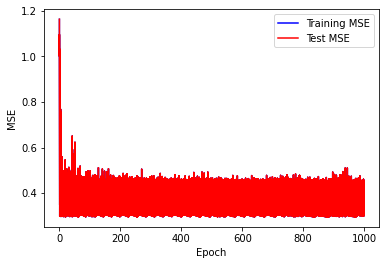

In [90]:
rank = 10
numItems = items.max() + 1
numUsers = users.max() + 1
P = torch.randn(numItems, rank, requires_grad=True)
Q = torch.randn(numUsers, rank, requires_grad=True)

# Global Baseline Estimate 적용시 bias_item, bias_user, Pi, Qx를 정규화하기 위해 사용
lambda1 = 0.0001
lambda2 = 0.0001
lambda3 = 0.001
lambda4 = 0.001

# 각 item, user 벡터에 적용할 bias 값
# 학습해야하는 파라미터이기에 랜덤한 값으로 채워넣는다.
bias_item = torch.randn(numItems, requires_grad=True)
bias_user = torch.randn(numUsers, requires_grad=True)

# 전체 평점 평균 (Global Baseline Estimate를 적용한 Latent Factor model의 가설함수에 필요)
mean = (ratings.sum() / len(ratings)).item()

optimizer = torch.optim.Adam([P, Q, bias_item, bias_user], lr= 0.1)

X = []
Y = []
Y_test = []
pp = []
qq = []

for epoch in range(1000):
    
    for i in range(len(quantiles)):
        
        # 가설 = 예상별점(아이템벡터와 유저벡터 내적) + 전체평점평균 + 아이템벡터의 bias + 유저벡터의 bias
        hypothesis = torch.sum(P[items] * Q[users], dim=1) + mean + bias_item[items] + bias_user[users]

        # 비용 = MSE + 정규화
        cost = quantile_loss2(hypothesis, ratings, quantiles)[i]
        loss = cost + lambda1 * torch.sum(P ** 2) + lambda2 * torch.sum(Q ** 2) + lambda3 * torch.sum(bias_item ** 2) + lambda4 * torch.sum(bias_user ** 2) 

        # 기울기 계산
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 기울기 계산 필요 없다.
        with torch.no_grad():
                    # 만들어진 P, Q matrix로 예측값을 뽑아내고 검증데이터와 비교한다.

                    # 가설 = 예상별점(아이템벡터와 유저벡터 내적) + 전체평점평균 + 아이템벡터의 bias + 유저벡터의 bias
            hypo_test = torch.sum(P[items_test] * Q[users_test], dim=1)+ mean + bias_item[items_test] + bias_user[users_test]


                    # 비용 = MSE
            cost_test = quantile_loss2(hypothesis, ratings, quantiles)[i]

                    # cost 결과 작성
            X.append(epoch)
            Y.append(cost)
            Y_test.append(cost_test)
            pp.append(P)
            qq.append(Q)

        if epoch % 100 == 0:
            print("epoch: {}, cost: {:.6f}" .format(epoch, cost.item()))

plt.ylabel("MSE")
plt.xlabel("Epoch")
plt.plot(X,Y, c="blue", label="Training MSE")
plt.plot(X,Y_test, c="red", label="Test MSE")
plt.legend()
plt.show()

In [ ]:
dtype = torch.float
X = np.random.normal(scale=1./latent_k, size = (user_num, latent_k))
Y = np.random.normal(scale=1./latent_k, size = (item_num, latent_k))
x_torch = torch.from_numpy(X)
y_torch = torch.from_numpy(Y)

learning_rate = 0.01
r_lambda = 0.01
steps = 1000
rmse_list = []

for i in range(steps):
    for i, j, r in non_zeros:
        e_ij = r - np.dot(x_torch[i, :], y_torch[j, :].T)
        x_torch[i,:] = x_torch[i,:] + learning_rate * (e_ij * y_torch[j, :] - r_lambda * x_torch[i, :])
        y_torch[j,:] = y_torch[j,:] + learning_rate * (e_ij * x_torch[i, :] - r_lambda * y_torch[j, :])
    
    rmse = get_rmse(movie_matrix, x_torch, y_torch, non_zeros)
    if (step % 10) == 0:
        rmse_list.append(rmse)
        print("##### iteration step :" , step, "rmse : ", rmse)

In [196]:
x_torch.shape, y_torch.shape

(torch.Size([943, 50]), torch.Size([1682, 50]))

In [205]:
P.shape, Q.shape

(torch.Size([944, 50]), torch.Size([1683, 50]))

In [197]:
pn = np.random.normal(scale=1./latent_k, size = (item_num, latent_k))
P = torch.from_numpy(pn)

In [204]:
qn = np.random.normal(scale=1./rank, size = (numItems, rank))
Q = torch.from_numpy(qn)

epoch: 0, cost: 0.363539
epoch: 100, cost: 0.343308
epoch: 200, cost: 0.342958
epoch: 300, cost: 0.342764
epoch: 400, cost: 0.343135
epoch: 500, cost: 0.342592
epoch: 600, cost: 0.342517
epoch: 700, cost: 0.342476
epoch: 800, cost: 0.342457
epoch: 900, cost: 0.342452


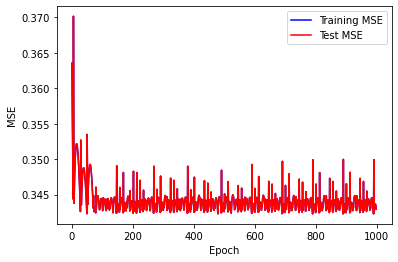

In [212]:
rank = 50
dtype = torch.float
numItems = items.max() + 1
numUsers = users.max() + 1
#P = torch.randn(numItems, rank, requires_grad=True)
qn = np.random.normal(scale=1./rank, size = (numUsers, rank))
Q = torch.from_numpy(qn)
#Q = torch.randn(numUsers, rank, requires_grad=True)
pn = np.random.normal(scale=1./rank, size = (numItems, rank))
P = torch.from_numpy(pn)

# Global Baseline Estimate 적용시 bias_item, bias_user, Pi, Qx를 정규화하기 위해 사용
lambda1 = 0.0001
lambda2 = 0.0001
lambda3 = 0.001
lambda4 = 0.001

# 각 item, user 벡터에 적용할 bias 값
# 학습해야하는 파라미터이기에 랜덤한 값으로 채워넣는다.
bias_item = torch.randn(numItems, requires_grad=True)
bias_user = torch.randn(numUsers, requires_grad=True)

# 전체 평점 평균 (Global Baseline Estimate를 적용한 Latent Factor model의 가설함수에 필요)
mean = (ratings.sum() / len(ratings)).item()

optimizer = torch.optim.Adam([P, Q, bias_item, bias_user], lr= 0.1)

X = []
Y = []
Y_test = []
pp = []
qq = []

for epoch in range(1000):
    
    # 가설 = 예상별점(아이템벡터와 유저벡터 내적) + 전체평점평균 + 아이템벡터의 bias + 유저벡터의 bias
    hypothesis = torch.sum(P[items] * Q[users], dim=1) + mean + bias_item[items] + bias_user[users]

    # 비용 = MSE + 정규화
    cost = quantile_loss2(hypothesis, ratings, quantiles)[0]
    loss = cost + lambda1 * torch.sum(P ** 2) + lambda2 * torch.sum(Q ** 2) + lambda3 * torch.sum(bias_item ** 2) + lambda4 * torch.sum(bias_user ** 2) 

    # 기울기 계산
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # 기울기 계산 필요 없다.
    with torch.no_grad():
                # 만들어진 P, Q matrix로 예측값을 뽑아내고 검증데이터와 비교한다.

                # 가설 = 예상별점(아이템벡터와 유저벡터 내적) + 전체평점평균 + 아이템벡터의 bias + 유저벡터의 bias
        hypo_test = torch.sum(P[items_test] * Q[users_test], dim=1)+ mean + bias_item[items_test] + bias_user[users_test]


                # 비용 = MSE
        cost_test = quantile_loss2(hypothesis, ratings, quantiles)[0]

                # cost 결과 작성
        X.append(epoch)
        Y.append(cost)
        Y_test.append(cost_test)
        pp.append(P)
        qq.append(Q)

    if epoch % 100 == 0:
        print("epoch: {}, cost: {:.6f}" .format(epoch, cost.item()))

plt.ylabel("MSE")
plt.xlabel("Epoch")
plt.plot(X,Y, c="blue", label="Training MSE")
plt.plot(X,Y_test, c="red", label="Test MSE")
plt.legend()
plt.show()

In [213]:
pred_matrix = torch.matmul(P, Q.T)
pred_matrix.shape
pred_matrix

tensor([[-2.0508e-04, -6.0404e-04,  4.4066e-04,  ...,  2.1508e-03,
         -2.1259e-03, -1.9352e-03],
        [ 4.8262e-04,  6.4176e-04,  1.2543e-03,  ..., -1.9299e-03,
          2.3432e-03, -4.3844e-03],
        [ 1.0658e-04, -2.9173e-03,  4.6512e-03,  ...,  1.2997e-03,
         -1.0466e-03, -9.9989e-04],
        ...,
        [-1.9442e-04,  2.3118e-03, -2.8538e-03,  ..., -2.5332e-03,
         -5.0572e-03,  1.7154e-03],
        [-2.3502e-04, -4.9443e-03, -1.4428e-03,  ...,  5.7486e-03,
          1.2965e-03,  2.8176e-03],
        [ 9.1577e-04,  1.1903e-03, -5.6259e-04,  ...,  7.7941e-05,
          3.8248e-04,  4.2730e-04]], dtype=torch.float64)

epoch: 0, cost: 0.571850
epoch: 100, cost: 0.452603
epoch: 200, cost: 0.449636
epoch: 300, cost: 0.456756
epoch: 400, cost: 0.457207
epoch: 500, cost: 0.455755
epoch: 600, cost: 0.455803
epoch: 700, cost: 0.449774
epoch: 800, cost: 0.449250
epoch: 900, cost: 0.450294


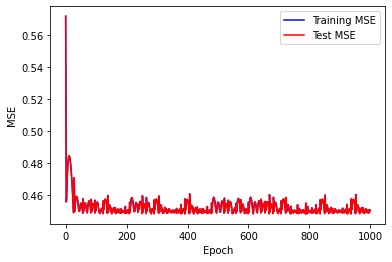

In [214]:
rank = 50
dtype = torch.float
numItems = items.max() + 1
numUsers = users.max() + 1
#P = torch.randn(numItems, rank, requires_grad=True)
qn = np.random.normal(scale=1./rank, size = (numUsers, rank))
Q = torch.from_numpy(qn)
#Q = torch.randn(numUsers, rank, requires_grad=True)
pn = np.random.normal(scale=1./rank, size = (numItems, rank))
P = torch.from_numpy(pn)

# Global Baseline Estimate 적용시 bias_item, bias_user, Pi, Qx를 정규화하기 위해 사용
lambda1 = 0.0001
lambda2 = 0.0001
lambda3 = 0.001
lambda4 = 0.001

# 각 item, user 벡터에 적용할 bias 값
# 학습해야하는 파라미터이기에 랜덤한 값으로 채워넣는다.
bias_item = torch.randn(numItems, requires_grad=True)
bias_user = torch.randn(numUsers, requires_grad=True)

# 전체 평점 평균 (Global Baseline Estimate를 적용한 Latent Factor model의 가설함수에 필요)
mean = (ratings.sum() / len(ratings)).item()

optimizer = torch.optim.Adam([P, Q, bias_item, bias_user], lr= 0.1)

X = []
Y = []
Y_test = []
pp = []
qq = []

for epoch in range(1000):
    
    # 가설 = 예상별점(아이템벡터와 유저벡터 내적) + 전체평점평균 + 아이템벡터의 bias + 유저벡터의 bias
    hypothesis = torch.sum(P[items] * Q[users], dim=1) + mean + bias_item[items] + bias_user[users]

    # 비용 = MSE + 정규화
    cost = quantile_loss2(hypothesis, ratings, quantiles)[1]
    loss = cost + lambda1 * torch.sum(P ** 2) + lambda2 * torch.sum(Q ** 2) + lambda3 * torch.sum(bias_item ** 2) + lambda4 * torch.sum(bias_user ** 2) 

    # 기울기 계산
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # 기울기 계산 필요 없다.
    with torch.no_grad():
                # 만들어진 P, Q matrix로 예측값을 뽑아내고 검증데이터와 비교한다.

                # 가설 = 예상별점(아이템벡터와 유저벡터 내적) + 전체평점평균 + 아이템벡터의 bias + 유저벡터의 bias
        hypo_test = torch.sum(P[items_test] * Q[users_test], dim=1)+ mean + bias_item[items_test] + bias_user[users_test]


                # 비용 = MSE
        cost_test = quantile_loss2(hypothesis, ratings, quantiles)[1]

                # cost 결과 작성
        X.append(epoch)
        Y.append(cost)
        Y_test.append(cost_test)
        pp.append(P)
        qq.append(Q)

    if epoch % 100 == 0:
        print("epoch: {}, cost: {:.6f}" .format(epoch, cost.item()))

plt.ylabel("MSE")
plt.xlabel("Epoch")
plt.plot(X,Y, c="blue", label="Training MSE")
plt.plot(X,Y_test, c="red", label="Test MSE")
plt.legend()
plt.show()

In [215]:
pred_matrix2 = torch.matmul(P, Q.T)
pred_matrix2.shape
pred_matrix2

tensor([[ 4.6775e-03, -5.2865e-04, -2.4172e-03,  ..., -2.9742e-03,
         -6.7775e-04,  6.5472e-06],
        [ 1.4932e-03, -1.3303e-03,  2.4155e-03,  ..., -2.3966e-03,
         -1.0901e-04,  4.9629e-04],
        [-3.3284e-03, -2.2557e-03, -3.3085e-03,  ..., -9.1378e-05,
          5.1936e-03, -6.2738e-04],
        ...,
        [-1.8066e-03, -3.9038e-03, -1.0616e-03,  ..., -1.5745e-03,
          1.5504e-03,  5.1953e-05],
        [ 2.8460e-03, -3.1503e-03, -1.5718e-03,  ..., -1.0311e-03,
          1.0945e-03, -8.6823e-04],
        [-1.6062e-04, -1.0370e-03,  6.5843e-04,  ...,  9.6817e-04,
          9.0810e-04, -4.6271e-03]], dtype=torch.float64)

epoch: 0, cost: 0.545645
epoch: 100, cost: 0.296483
epoch: 200, cost: 0.295845
epoch: 300, cost: 0.296279
epoch: 400, cost: 0.297327
epoch: 500, cost: 0.296707
epoch: 600, cost: 0.298763
epoch: 700, cost: 0.297573
epoch: 800, cost: 0.297286
epoch: 900, cost: 0.296012


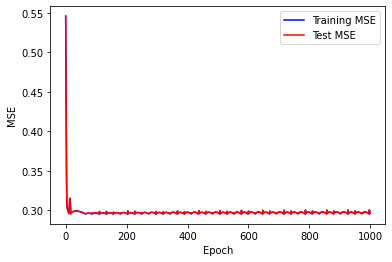

In [216]:
rank = 50
dtype = torch.float
numItems = items.max() + 1
numUsers = users.max() + 1
#P = torch.randn(numItems, rank, requires_grad=True)
qn = np.random.normal(scale=1./rank, size = (numUsers, rank))
Q = torch.from_numpy(qn)
#Q = torch.randn(numUsers, rank, requires_grad=True)
pn = np.random.normal(scale=1./rank, size = (numItems, rank))
P = torch.from_numpy(pn)

# Global Baseline Estimate 적용시 bias_item, bias_user, Pi, Qx를 정규화하기 위해 사용
lambda1 = 0.0001
lambda2 = 0.0001
lambda3 = 0.001
lambda4 = 0.001

# 각 item, user 벡터에 적용할 bias 값
# 학습해야하는 파라미터이기에 랜덤한 값으로 채워넣는다.
bias_item = torch.randn(numItems, requires_grad=True)
bias_user = torch.randn(numUsers, requires_grad=True)

# 전체 평점 평균 (Global Baseline Estimate를 적용한 Latent Factor model의 가설함수에 필요)
mean = (ratings.sum() / len(ratings)).item()

optimizer = torch.optim.Adam([P, Q, bias_item, bias_user], lr= 0.1)

X = []
Y = []
Y_test = []
pp = []
qq = []

for epoch in range(1000):
    
    # 가설 = 예상별점(아이템벡터와 유저벡터 내적) + 전체평점평균 + 아이템벡터의 bias + 유저벡터의 bias
    hypothesis = torch.sum(P[items] * Q[users], dim=1) + mean + bias_item[items] + bias_user[users]

    # 비용 = MSE + 정규화
    cost = quantile_loss2(hypothesis, ratings, quantiles)[2]
    loss = cost + lambda1 * torch.sum(P ** 2) + lambda2 * torch.sum(Q ** 2) + lambda3 * torch.sum(bias_item ** 2) + lambda4 * torch.sum(bias_user ** 2) 

    # 기울기 계산
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # 기울기 계산 필요 없다.
    with torch.no_grad():
                # 만들어진 P, Q matrix로 예측값을 뽑아내고 검증데이터와 비교한다.

                # 가설 = 예상별점(아이템벡터와 유저벡터 내적) + 전체평점평균 + 아이템벡터의 bias + 유저벡터의 bias
        hypo_test = torch.sum(P[items_test] * Q[users_test], dim=1)+ mean + bias_item[items_test] + bias_user[users_test]


                # 비용 = MSE
        cost_test = quantile_loss2(hypothesis, ratings, quantiles)[2]

                # cost 결과 작성
        X.append(epoch)
        Y.append(cost)
        Y_test.append(cost_test)
        pp.append(P)
        qq.append(Q)

    if epoch % 100 == 0:
        print("epoch: {}, cost: {:.6f}" .format(epoch, cost.item()))

plt.ylabel("MSE")
plt.xlabel("Epoch")
plt.plot(X,Y, c="blue", label="Training MSE")
plt.plot(X,Y_test, c="red", label="Test MSE")
plt.legend()
plt.show()

In [217]:
pred_matrix3 = torch.matmul(P, Q.T)
pred_matrix3.shape
pred_matrix3

tensor([[ 1.6036e-03, -4.3686e-03,  2.0664e-03,  ..., -4.6880e-03,
          3.6035e-03, -4.4640e-03],
        [ 1.2074e-03, -1.1495e-03, -1.5553e-03,  ...,  1.9586e-03,
          1.2771e-04, -5.0606e-03],
        [ 2.0690e-03, -2.1830e-04, -7.6334e-04,  ..., -6.3921e-04,
         -8.3022e-04, -4.6603e-03],
        ...,
        [-5.2068e-04, -8.8221e-04,  1.2557e-03,  ..., -3.1946e-05,
          1.6914e-04, -1.1651e-03],
        [ 5.4876e-04, -1.0061e-03,  1.1531e-03,  ..., -3.0875e-03,
          6.0093e-03, -5.6476e-04],
        [ 2.8494e-04,  2.3687e-03,  4.1721e-03,  ..., -2.9030e-04,
         -6.3558e-04,  9.0041e-04]], dtype=torch.float64)

In [137]:
pred_m = [pred_matrix, pred_matrix2, pred_matrix3]

In [101]:
p2 = pp[2997]
p5 = pp[2998]
p8 = pp[2999]

In [102]:
q2 = qq[2997]
q5 = qq[2998]
q8 = qq[2999]

In [104]:
def pred_matrix(p, q):
    matrix_list = []
    for i in range(3):
        pred_matrix = torch.matmul(pp[2999 - i], qq[2999 - i].T)
        matrix_list.append(pred_matrix)
    return matrix_list

In [106]:
pm = pred_matrix(pp, qq)

In [187]:
pred_matrix = torch.matmul(P, Q.T)
pred_matrix.shape
pred_matrix

tensor([[ 0.0000e+00,  1.1816e-23,  1.9343e-24,  ...,  9.8016e-24,
          3.8362e-24,  1.5912e-23],
        [-1.3104e-23,  8.2766e-01,  3.0546e-01,  ...,  4.9226e-01,
          9.5074e-01,  5.4294e-01],
        [-5.0596e-24, -4.2312e-02, -4.7540e-02,  ...,  1.1551e-01,
          2.2337e-01,  3.4037e-02],
        ...,
        [ 1.1385e-24, -1.8156e-01, -3.8075e-02,  ..., -2.3237e-02,
         -2.8773e-02, -2.8511e-01],
        [-1.5801e-25, -2.4205e-02,  2.1261e-03,  ..., -1.0979e-02,
         -8.9747e-03, -3.8844e-02],
        [-8.0926e-26, -5.2894e-02, -1.4279e-02,  ..., -9.5606e-03,
         -7.9128e-03, -3.3883e-02]], grad_fn=<MmBackward>)

In [88]:
pred_matrix = torch.matmul(P, Q.T)
pred_matrix.shape
pred_matrix

tensor([[ 0.0000e+00, -1.7219e-40,  0.0000e+00,  ..., -4.6243e-43,
          0.0000e+00,  0.0000e+00],
        [ 1.2272e-40, -2.5643e-01,  3.9463e-40,  ..., -1.0598e-04,
          1.2583e-16,  1.0020e-09],
        [-5.6533e-41,  6.6901e-03, -1.5845e-40,  ..., -2.8901e-05,
          1.5395e-17,  5.6423e-11],
        ...,
        [ 0.0000e+00,  2.5709e-21,  0.0000e+00,  ..., -1.2191e-42,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00, -2.8920e-17,  0.0000e+00,  ..., -1.8077e-43,
          1.1225e-31,  0.0000e+00],
        [ 0.0000e+00, -3.1431e-17,  0.0000e+00,  ..., -9.6830e-43,
          0.0000e+00,  0.0000e+00]], grad_fn=<MmBackward>)

In [154]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=419)

In [155]:
items = torch.LongTensor(df_train['movieidx'].to_numpy())
users = torch.LongTensor(df_train['useridx'].to_numpy())
ratings = torch.FloatTensor(df_train['rating'].to_numpy())
items_test = torch.LongTensor(df_test['movieidx'].to_numpy())
users_test = torch.LongTensor(df_test['useridx'].to_numpy())
ratings_test = torch.FloatTensor(df_test['rating'].to_numpy())
numitem = items.max() + 1
numuser = users.max() + 1

In [218]:
import glob
from datetime import date
import logging

In [219]:
if glob.glob('log') != ['logs']:
    os.mkdir('logs')
else:
    pass

if glob.glob('weights') != ['weights']:
    os.mkdir('weights')
else:
    pass

In [288]:
if glob.glob('log2') != ['logs2']:
    os.mkdir('logs2')
else:
    pass

if glob.glob('weights2') != ['weights2']:
    os.mkdir('weights2')
else:
    pass

In [220]:
log_model = 'nmf'

today = date.today()
log_formatter = logging.Formatter("%(asctime)s %(message)s")
logger = logging.getLogger()

log_file_name = "./logs/{}_{}".format(today, log_model)

file_handler = logging.FileHandler("{}.log".format(log_file_name))
file_handler.setFormatter(log_formatter)
logger.addHandler(file_handler)
logger.setLevel(logging.DEBUG)

In [222]:
df

,user_id,item_id,rating,timestamp
0,196,242,3.0,881250949
1,186,302,3.0,891717742
2,22,377,1.0,878887116
3,244,51,2.0,880606923
4,166,346,1.0,886397596
...,...,...,...,...
99995,880,476,3.0,880175444
99996,716,204,5.0,879795543
99997,276,1090,1.0,874795795
99998,13,225,2.0,882399156


In [226]:
num_users = df.user_id.unique().shape[0]
num_items = df.item_id.unique().shape[0]
print('유저의 수 : %d, 영화의 수 : %d' %(num_users, num_items))

유저의 수 : 943, 영화의 수 : 1682


In [227]:
from torch.utils.data import Dataset, TensorDataset, DataLoader

In [228]:
class CustomDataset(Dataset):
    def __init__(self, users, items, y):
        self.x = torch.cat([
            torch.LongTensor(users).unsqueeze(0).transpose(0, 1),
            torch.LongTensor(items).unsqueeze(0).transpose(0, 1)
        ], axis=1)
        self.y = torch.FloatTensor(y)

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return len(self.y)

In [229]:
from sklearn import preprocessing

In [245]:
le1 = preprocessing.LabelEncoder()
le2 = preprocessing.LabelEncoder()

batch_size = 256

train_dataset = CustomDataset(
    le1.fit_transform(df.user_id),
    le2.fit_transform(df.item_id),
    df.rating.values
)
train_loader = DataLoader(train_dataset, batch_size=batch_size)

In [246]:
train_dataset[0]

(tensor([195, 241]), tensor(3.))

In [247]:
train_dataset[1]

(tensor([185, 301]), tensor(3.))

In [248]:
df

,user_id,item_id,rating,timestamp
0,196,242,3.0,881250949
1,186,302,3.0,891717742
2,22,377,1.0,878887116
3,244,51,2.0,880606923
4,166,346,1.0,886397596
...,...,...,...,...
99995,880,476,3.0,880175444
99996,716,204,5.0,879795543
99997,276,1090,1.0,874795795
99998,13,225,2.0,882399156


In [249]:
class MF(nn.Module):
    def __init__(self, num_users, num_items, emb_size=128):
        super(MF, self).__init__()
        self.user_emb = nn.Embedding(num_users, emb_size)
        self.item_emb = nn.Embedding(num_items, emb_size)
        self.user_emb.weight.data.uniform_(0, 0.05)
        self.item_emb.weight.data.uniform_(0, 0.05)
        
    def forward(self, data):
        x, y = data[:,:1], data[:,1:]
        u, v = self.user_emb(x), self.item_emb(y)
        return (u.squeeze(1) * v.squeeze(1)).sum(1)

In [250]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

print('사용할 device : %s' % device)

사용할 device : cuda


In [251]:
model = MF(num_users, num_items, emb_size = 128).to(device)
print('모델 구성 : \n\n', model)

모델 구성 : 

 MF(
  (user_emb): Embedding(943, 128)
  (item_emb): Embedding(1682, 128)
)


In [252]:
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
loss_fn = torch.nn.MSELoss()

In [253]:
model.train()

EPOCHS = 10

for e in range(EPOCHS):
    print('start : ' + str(e) + ' epoch')
    avg_loss = 0
    for batch_idx, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        y_hat = model(x)
        loss = loss_fn(y_hat, y)
        avg_loss += loss.item()
        loss.backward()
        optimizer.step()
    torch.save(model.state_dict(), "./weights/{}_{}.pt".format(log_model, e+1))
    print("e{}:loss : {}".format(e+1, loss/(batch_idx + 1)))
    logger.info("e{} : loss : {}".format(e+1, loss/(batch_idx + 1)))
print('training complete')


start : 0epoch
e1:loss : 0.0041188946925103664
start : 1epoch
e2:loss : 0.003433085512369871
start : 2epoch
e3:loss : 0.001565714948810637
start : 3epoch
e4:loss : 0.001177519210614264
start : 4epoch
e5:loss : 0.00221115886233747
start : 5epoch
e6:loss : 0.0024741273373365402
start : 6epoch
e7:loss : 0.002002481371164322
start : 7epoch
e8:loss : 0.0016794916009530425
start : 8epoch
e9:loss : 0.0013082714285701513
start : 9epoch
e10:loss : 0.0013727473560720682
training complete


In [254]:
model.eval()

MF(
  (user_emb): Embedding(943, 128)
  (item_emb): Embedding(1682, 128)
)

In [256]:
df['le_UserID'] = le1.fit_transform(df.user_id)
df['le_ItemID'] = le1.fit_transform(df.item_id)

df

,user_id,item_id,rating,timestamp,le_UserID,le_ItemID
0,196,242,3.0,881250949,195,241
1,186,302,3.0,891717742,185,301
2,22,377,1.0,878887116,21,376
3,244,51,2.0,880606923,243,50
4,166,346,1.0,886397596,165,345
...,...,...,...,...,...,...
99995,880,476,3.0,880175444,879,475
99996,716,204,5.0,879795543,715,203
99997,276,1090,1.0,874795795,275,1089
99998,13,225,2.0,882399156,12,224


In [258]:
val_tensor = torch.LongTensor(df[['le_UserID', 'le_ItemID']].values).to(device)
pred = model(torch.LongTensor(df[['le_UserID', 'le_ItemID']].values).to(device))

In [259]:
df['pred_rating'] = pred.to('cpu').detach().numpy()

In [260]:
df

,user_id,item_id,rating,timestamp,le_UserID,le_ItemID,pred_rating
0,196,242,3.0,881250949,195,241,3.531374
1,186,302,3.0,891717742,185,301,2.474723
2,22,377,1.0,878887116,21,376,0.151213
3,244,51,2.0,880606923,243,50,1.888791
4,166,346,1.0,886397596,165,345,0.281685
...,...,...,...,...,...,...,...
99995,880,476,3.0,880175444,879,475,3.136700
99996,716,204,5.0,879795543,715,203,4.744420
99997,276,1090,1.0,874795795,275,1089,2.139551
99998,13,225,2.0,882399156,12,224,2.008213


In [266]:
from sklearn.metrics import mean_squared_error

In [267]:
mean_squared_error(df['rating'], df['pred_rating'])

0.6289450055305855

In [277]:
sum((df['rating'] - df['pred_rating']) ** 2) / len(df)

0.628945005530569

In [280]:
model2 = MF(943, 1682, emb_size = 128).to(device)

model_path = './weights/nmf_10.pt'

model2.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [281]:
model2

MF(
  (user_emb): Embedding(943, 128)
  (item_emb): Embedding(1682, 128)
)

In [282]:
model2.eval()

MF(
  (user_emb): Embedding(943, 128)
  (item_emb): Embedding(1682, 128)
)

In [289]:
model2.train()

EPOCHS = 10

for e in range(EPOCHS):
    print('start : ' + str(e) + ' epoch')
    avg_loss = 0
    for batch_idx, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        y_hat = model2(x)
        loss = loss_fn(y_hat, y)
        avg_loss += loss.item()
        loss.backward()
        optimizer.step()
    torch.save(model2.state_dict(), "./weights2/{}_{}.pt".format(log_model, e+1))
    print("e{}:loss : {}".format(e+1, loss/(batch_idx + 1)))
    logger.info("e{} : loss : {}".format(e+1, loss/(batch_idx + 1)))
print('training complete')


start : 0 epoch
e1:loss : 0.0006637969054281712
start : 1 epoch
e2:loss : 0.0006637969054281712
start : 2 epoch
e3:loss : 0.0006637969054281712
start : 3 epoch
e4:loss : 0.0006637969054281712
start : 4 epoch
e5:loss : 0.0006637969054281712
start : 5 epoch
e6:loss : 0.0006637969054281712
start : 6 epoch
e7:loss : 0.0006637969054281712
start : 7 epoch
e8:loss : 0.0006637969054281712
start : 8 epoch
e9:loss : 0.0006637969054281712
start : 9 epoch
e10:loss : 0.0006637969054281712
training complete


In [290]:
val_tensor2 = torch.LongTensor(df[['le_UserID', 'le_ItemID']].values).to(device)
pred2 = model2(torch.LongTensor(df[['le_UserID', 'le_ItemID']].values).to(device))

In [291]:
df['pred_rating2'] = pred2.to('cpu').detach().numpy()

In [292]:
df

,user_id,item_id,rating,timestamp,le_UserID,le_ItemID,pred_rating,pred_rating2
0,196,242,3.0,881250949,195,241,3.531374,3.531374
1,186,302,3.0,891717742,185,301,2.474723,2.474723
2,22,377,1.0,878887116,21,376,0.151213,0.151213
3,244,51,2.0,880606923,243,50,1.888791,1.888791
4,166,346,1.0,886397596,165,345,0.281685,0.281685
...,...,...,...,...,...,...,...,...
99995,880,476,3.0,880175444,879,475,3.136700,3.136700
99996,716,204,5.0,879795543,715,203,4.744420,4.744420
99997,276,1090,1.0,874795795,275,1089,2.139551,2.139551
99998,13,225,2.0,882399156,12,224,2.008213,2.008213
